In [1]:
from Bio import AlignIO

alignment = AlignIO.read("covid_dataset/muscle-I20250605-061350-0210-51424077-p1m.aln-fasta", "fasta")

for record in alignment:
    print(f">{record.id}\n{record.seq[:100]}")


>PV361325.1
------------------------------------------TCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC
>OK091006.1
---------------------------CAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC
>OM287553.1
------------------------------------------------------AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC
>MN908947.3
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC


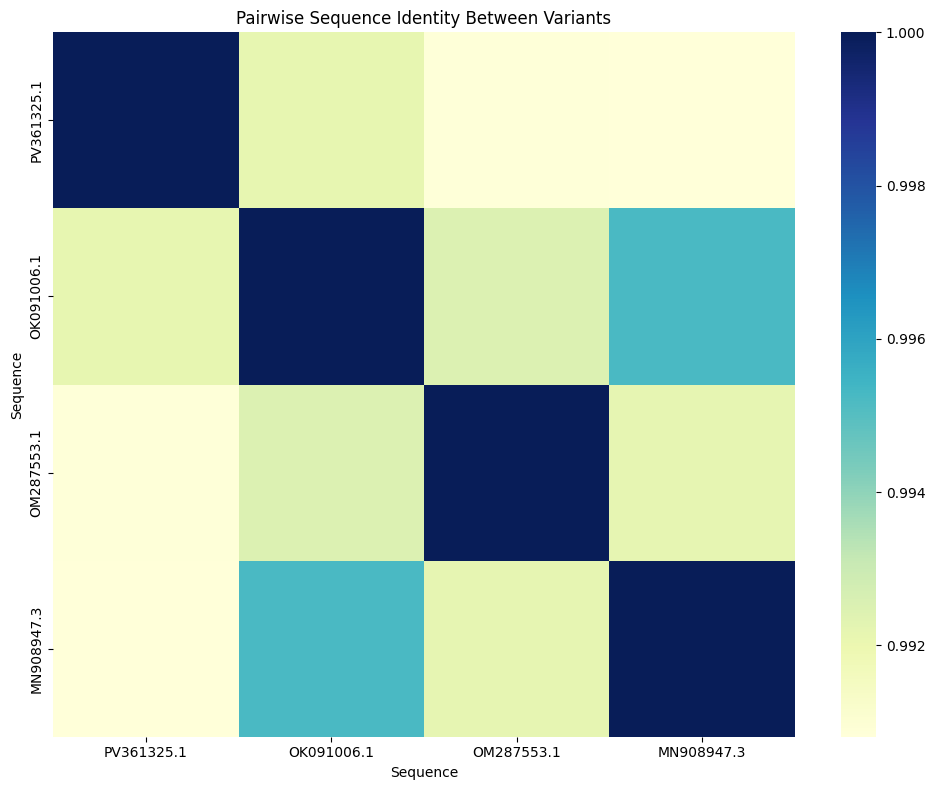

In [2]:
from Bio import AlignIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

alignment = AlignIO.read("covid_dataset/muscle-I20250605-061350-0210-51424077-p1m.aln-fasta", "fasta")
seqs = [str(rec.seq) for rec in alignment]
ids = [rec.id for rec in alignment]

n = len(seqs)
identity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        matches = sum(a == b for a, b in zip(seqs[i], seqs[j]))
        identity = matches / len(seqs[i])
        identity_matrix[i, j] = identity

plt.figure(figsize=(10, 8))
sns.heatmap(identity_matrix, xticklabels=ids, yticklabels=ids, cmap="YlGnBu", annot=False)
plt.title("Pairwise Sequence Identity Between Variants")
plt.xlabel("Sequence")
plt.ylabel("Sequence")
plt.savefig("results/pairwise_similarity_heatmap.png")
plt.tight_layout()
plt.show()


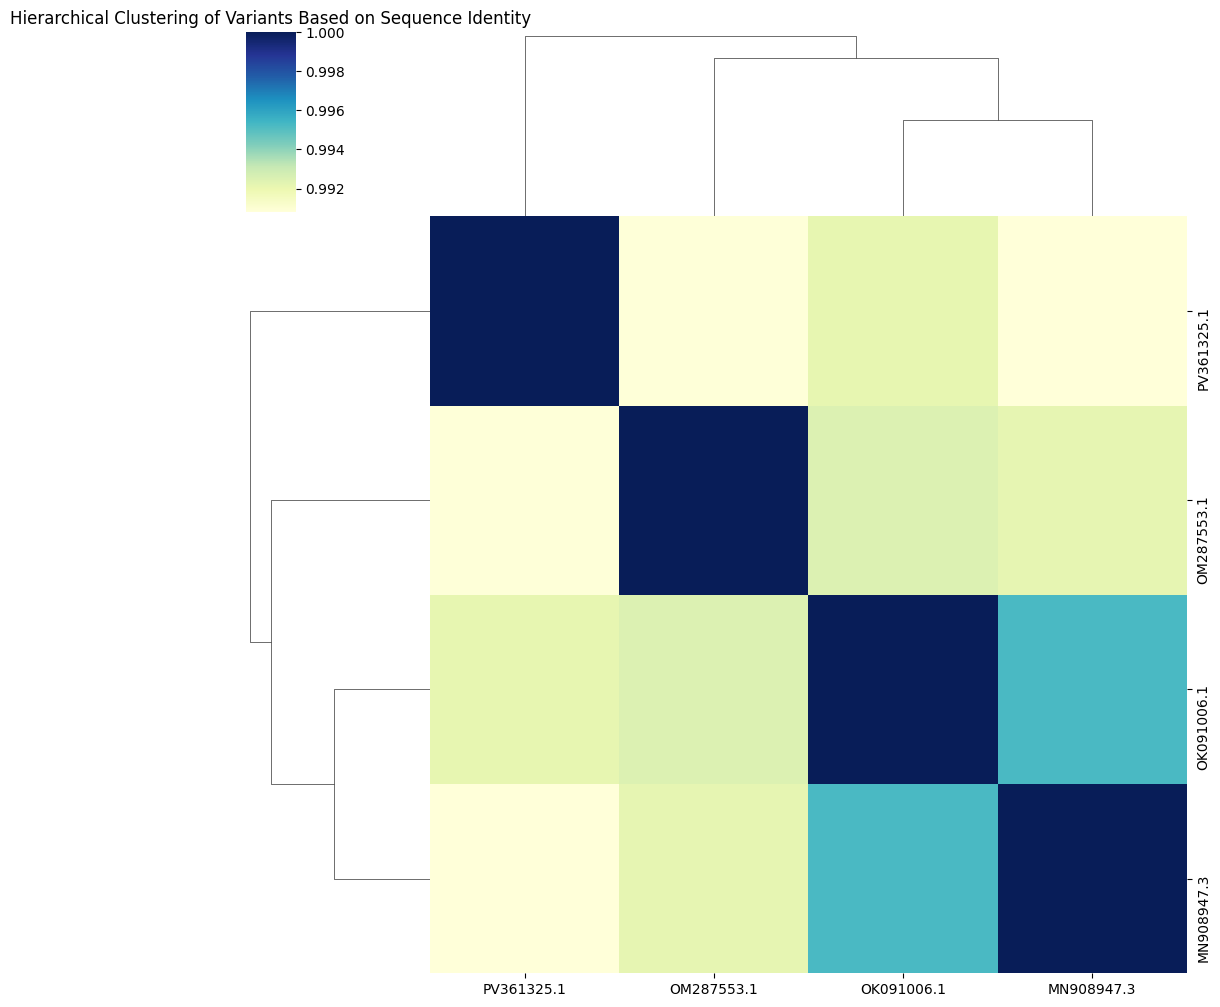

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(identity_matrix, 
               xticklabels=ids, 
               yticklabels=ids, 
               cmap="YlGnBu", 
               figsize=(10, 10))
plt.title("Hierarchical Clustering of Variants Based on Sequence Identity")
plt.savefig("results/cluster_heatmap.png")
plt.show()



Total depth: 89351

First 100 bases of depth coverage:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]

Relative Abundance (%):
Genome 1: 33.33%
Genome 2: 33.39%
Genome 3: 33.28%


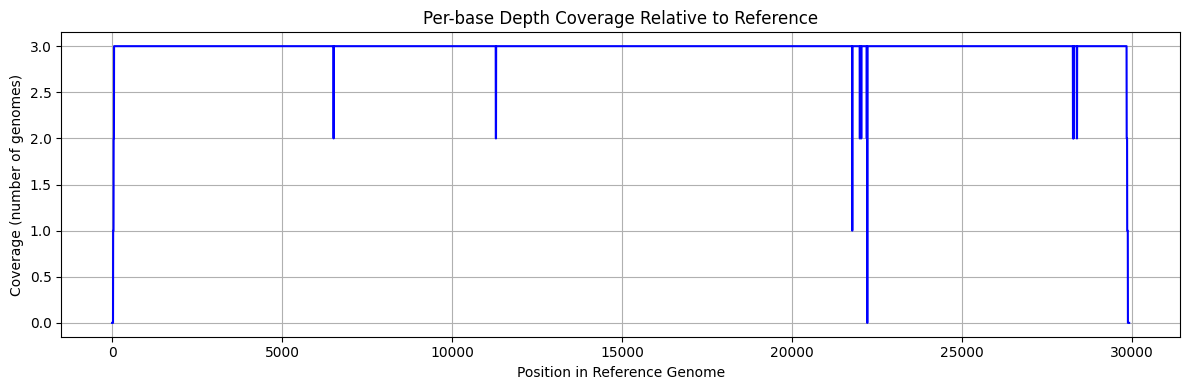

In [4]:
from Bio import AlignIO
import numpy as np

alignment = AlignIO.read("covid_dataset/muscle-I20250605-061350-0210-51424077-p1m.aln-fasta", "fasta")

reference_seq = alignment[3].seq

depth_coverage = np.zeros(len(reference_seq), dtype=int)

for i in range(len(reference_seq)):
    for record in alignment[:3]:  
        if record.seq[i] != '-' and reference_seq[i] != '-':
            depth_coverage[i] += 1

total_depth = sum(depth_coverage)

print(f"\nTotal depth: {total_depth}")
print("\nFirst 100 bases of depth coverage:")
print(depth_coverage[:100])

abundances = []
for record in alignment[:3]:
    aligned_bases = sum(1 for i in range(len(reference_seq))
                        if record.seq[i] != '-' and reference_seq[i] != '-')
    abundances.append(aligned_bases)

total_aligned = sum(abundances)
relative_abundances = [round(100 * a / total_aligned, 2) for a in abundances]

print("\nRelative Abundance (%):")
for i, perc in enumerate(relative_abundances, 1):
    print(f"Genome {i}: {perc}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(depth_coverage, color='blue')
plt.title("Per-base Depth Coverage Relative to Reference")
plt.xlabel("Position in Reference Genome")
plt.ylabel("Coverage (number of genomes)")
plt.savefig("results/depth_coverage.png")
plt.grid(True)
plt.tight_layout()
plt.show()

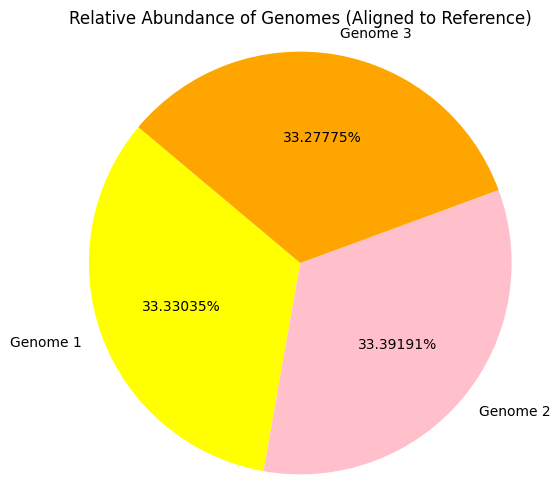

In [5]:
from Bio import SeqIO
alignment = AlignIO.read("covid_dataset/muscle-I20250605-061350-0210-51424077-p1m.aln-fasta", "fasta")

gb_record = SeqIO.read("covid_dataset/SARS-CoV-2_Wuhan-Hu-1_2019.gb", "genbank")

reference = alignment[3]

reference_seq = reference.seq

abundances = []
for record in alignment[:3]:
    aligned_bases = sum(1 for i in range(len(reference_seq))
                        if record.seq[i] != '-' and reference_seq[i] != '-')
    abundances.append(aligned_bases)

labels = ['Genome 1', 'Genome 2', 'Genome 3']
colors = ['yellow','pink','orange']

plt.figure(figsize=(6, 6))
plt.pie(abundances, labels=labels, autopct='%1.5f%%', colors=colors, startangle=140)
plt.title("Relative Abundance of Genomes (Aligned to Reference)")
plt.savefig("results/abundance_pie.png")
plt.axis('equal') 
plt.show()


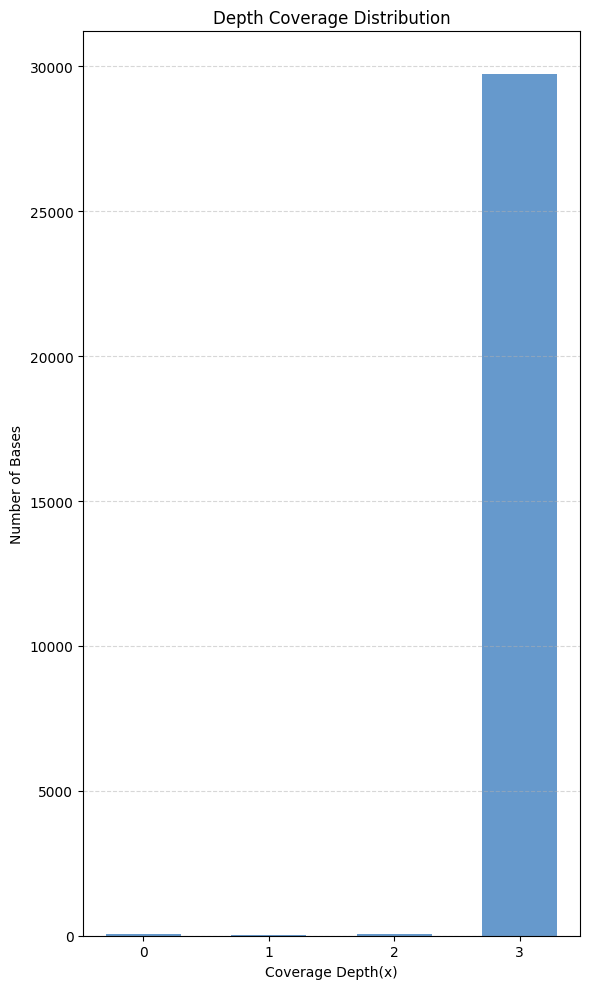

In [6]:
unique, counts = np.unique(depth_coverage, return_counts=True)

plt.figure(figsize=(6, 10))
plt.bar(unique, counts, color='#6699cc', width=0.6)
plt.xticks([0, 1, 2, 3])
plt.xlabel("Coverage Depth(x)")
plt.ylabel("Number of Bases")
plt.title("Depth Coverage Distribution")
plt.savefig("results/depth_coverage_distribution.png")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from Bio import SeqIO

reference = None
for record in alignment:
    if "MN908947.3" in record.id:
        reference = record
        break

if reference is None:
    raise ValueError("Reference genome MN908947.3 not found!")

mutations = []

for i in range(alignment.get_alignment_length()):
    ref_base = reference.seq[i]

    for record in alignment:
        if record.id == reference.id:
            continue
        var_base = record.seq[i]

        if var_base != ref_base:
            mutations.append({
                "Position": i + 1,
                "Reference_ID": reference.id,
                "Reference_Base": ref_base,
                "Variant_ID": record.id,
                "Variant_Base": var_base,
                "Type": (
                    "Insertion" if ref_base == "-" else
                    "Deletion" if var_base == "-" else
                    "SNP"
                )
            })

df = pd.DataFrame(mutations)
df.to_csv("covid_dataset/mutations_from_alignment.csv", index=False)
print(df)

     Position Reference_ID Reference_Base  Variant_ID Variant_Base      Type
0           1   MN908947.3              A  PV361325.1            -  Deletion
1           1   MN908947.3              A  OK091006.1            -  Deletion
2           1   MN908947.3              A  OM287553.1            -  Deletion
3           2   MN908947.3              T  PV361325.1            -  Deletion
4           2   MN908947.3              T  OK091006.1            -  Deletion
..        ...          ...            ...         ...          ...       ...
646     29911   MN908947.3              A  OK091006.1            -  Deletion
647     29911   MN908947.3              A  OM287553.1            -  Deletion
648     29912   MN908947.3              A  PV361325.1            -  Deletion
649     29912   MN908947.3              A  OK091006.1            -  Deletion
650     29912   MN908947.3              A  OM287553.1            -  Deletion

[651 rows x 6 columns]



Mutation counts per variant:
Variant_ID
PV361325.1    275
OM287553.1    234
OK091006.1    142
Name: count, dtype: int64


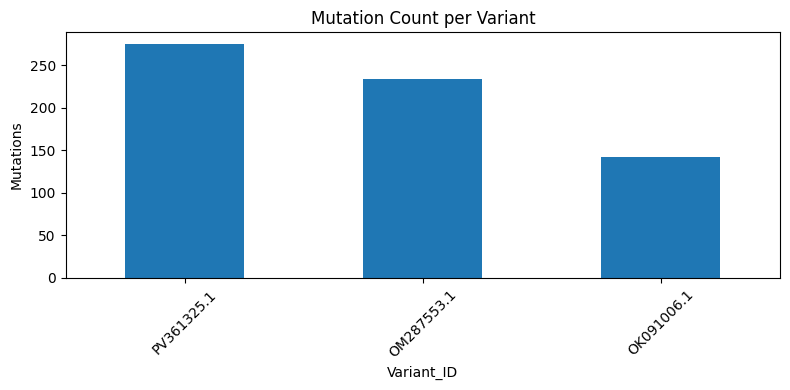

In [8]:
counts = df["Variant_ID"].value_counts()
print("\nMutation counts per variant:")
print(counts)

counts.plot(kind="bar", title="Mutation Count per Variant", ylabel="Mutations", figsize=(8, 4))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("results/mutation_count_per_variant.png")
plt.show()


Type
Deletion     358
SNP          284
Insertion      9
Name: count, dtype: int64


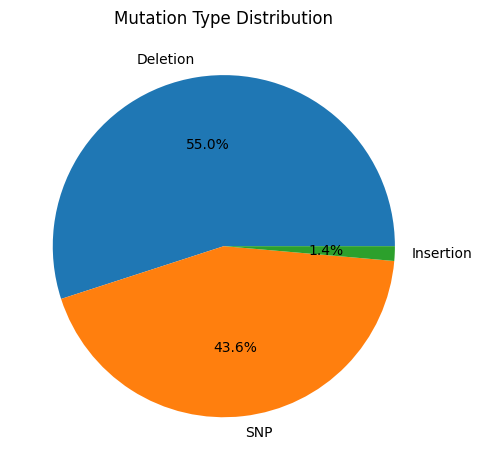

In [9]:
type_counts = df["Type"].value_counts()
print(type_counts)

type_counts.plot(kind="pie", autopct="%1.1f%%", title="Mutation Type Distribution")
plt.ylabel("")
plt.tight_layout()
plt.savefig("results/mutation_type_distribution.png")
plt.show()


Top 20 mutating positions:
Position
29881    3
29882    3
29883    3
29884    3
29885    3
29886    3
29887    3
29888    3
29889    3
29890    3
29891    3
29892    3
29893    3
29894    3
29895    3
29896    3
17       3
18       3
19       3
20       3
Name: count, dtype: int64


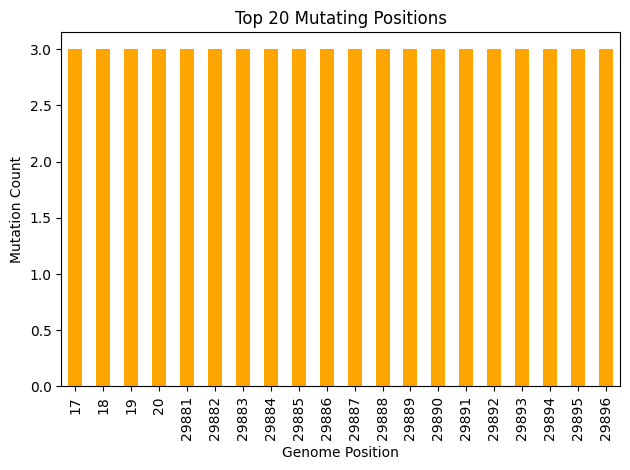

In [10]:
hotspots = df["Position"].value_counts().head(20)
print("Top 20 mutating positions:")
print(hotspots)

hotspots.sort_index().plot(kind="bar", title="Top 20 Mutating Positions", color='orange')
plt.xlabel("Genome Position")
plt.ylabel("Mutation Count")
plt.tight_layout()
plt.savefig("results/top_mutation_positions.png")
plt.show()


In [11]:
from Bio import SeqIO
import pandas as pd

df = pd.read_csv("covid_dataset/mutations_from_alignment.csv")

gb_record = SeqIO.read("covid_dataset/SARS-CoV-2_Wuhan-Hu-1_2019.gb", "genbank")

pos_to_gene = {}

for feature in gb_record.features:
    if feature.type in ["gene", "CDS"]:
        gene = feature.qualifiers.get("gene", ["unknown"])[0]
        for pos in range(int(feature.location.start) + 1, int(feature.location.end) + 1):
            pos_to_gene[pos] = gene

df["Gene"] = df["Position"].apply(lambda p: pos_to_gene.get(p, "intergenic"))

df.to_csv("results/mutations_annotated_with_genes.csv", index=False)
print("Success")


Success



Mutation Count per Gene:
Gene
intergenic    314
S             173
orf1ab        126
N              23
M               5
ORF3a           3
ORF8            3
ORF7a           2
E               1
ORF6            1
Name: count, dtype: int64


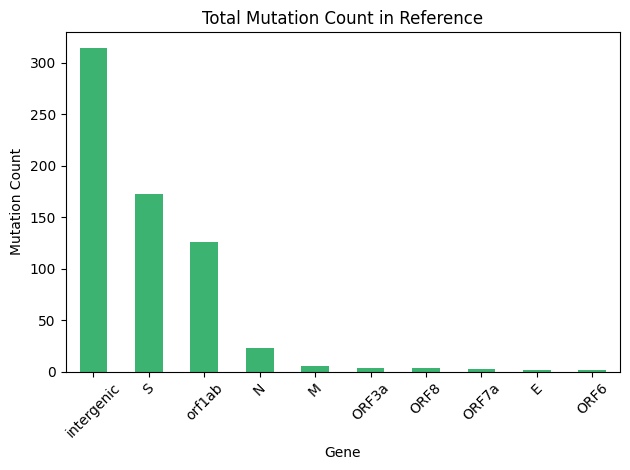

In [12]:
import matplotlib.pyplot as plt

df = pd.read_csv("results/mutations_annotated_with_genes.csv")

gene_counts = df["Gene"].value_counts()
print("\nMutation Count per Gene:")
print(gene_counts)

gene_counts.plot(kind="bar", title="Total Mutation Count in Reference", color="mediumseagreen")
plt.xlabel("Gene")
plt.ylabel("Mutation Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("results/total_mutation_count_per_gene_in_reference.png")
plt.show()


All available Variant_IDs:

['OK091006.1', 'OM287553.1', 'PV361325.1']
            E  M   N  ORF3a  ORF6  ORF7a  ORF8    S  intergenic  orf1ab  \
Variant_ID                                                                
OK091006.1  0  1   5      1     0      1     0   14          72      48   
OM287553.1  1  3  14      1     1      0     0   57         132      25   
PV361325.1  0  1   4      1     0      1     3  102         110      53   

            Total_Mutations  
Variant_ID                   
OK091006.1              142  
OM287553.1              234  
PV361325.1              275  


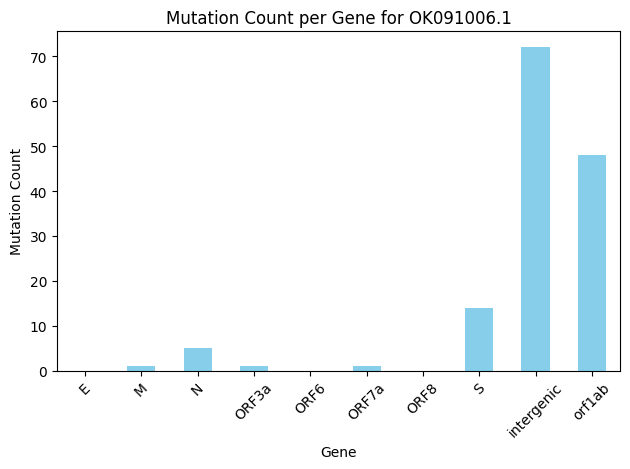

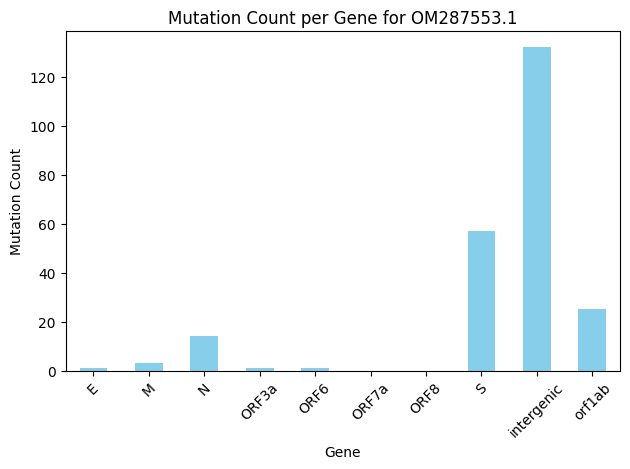

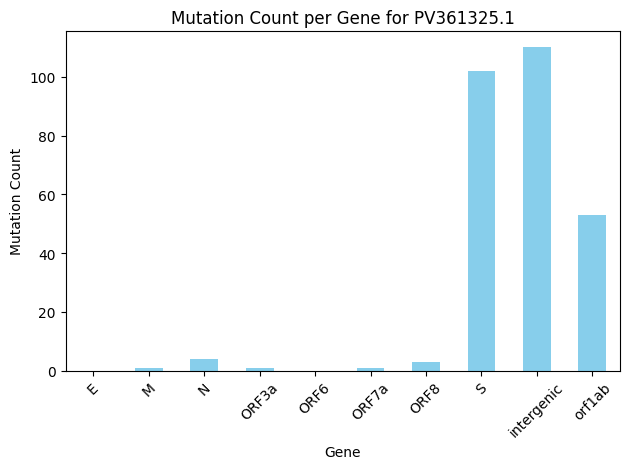

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/mutations_annotated_with_genes.csv")

mutation_by_variant = df.groupby(["Variant_ID", "Gene"]).size().unstack(fill_value=0)
mutation_by_variant.to_csv("results/mutation_count_per_gene_per_variant.csv")

print("All available Variant_IDs:\n")
print(mutation_by_variant.index.tolist())


df_count_per_variant = pd.read_csv("results/mutation_count_per_gene_per_variant.csv", index_col=0)

df_count_per_variant["Total_Mutations"] = df_count_per_variant.sum(axis=1)
df_count_per_variant.to_csv("results/mutation_count_per_gene_per_variant_with_total.csv")

print(df_count_per_variant)

for variant_to_plot in mutation_by_variant.index.tolist():
    variant_to_plot = variant_to_plot
    mutation_by_variant.loc[variant_to_plot].plot(kind="bar", color="skyblue")
    plt.title(f"Mutation Count per Gene for {variant_to_plot}")
    plt.xlabel("Gene")
    plt.ylabel("Mutation Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.tight_layout()
    plt.savefig(f"results/total_mutation_count_per_gene_in_{variant_to_plot}.png")
    plt.show()


In [14]:
from Bio import AlignIO, SeqIO
import pandas as pd

alignment = AlignIO.read("covid_dataset/muscle-I20250605-061350-0210-51424077-p1m.aln-fasta", "fasta")

gb_record = SeqIO.read("covid_dataset/SARS-CoV-2_Wuhan-Hu-1_2019.gb", "genbank")

reference = alignment[3]

ref_seq = reference.seq
ref_to_align_map = []  
ref_pos = 1  

for i, base in enumerate(ref_seq):
    if base != "-":
        ref_to_align_map.append((ref_pos, i)) 
        ref_pos += 1

gene_to_indices = {}

for feature in gb_record.features:
    if feature.type in ["gene", "CDS"]:
        gene_name = feature.qualifiers.get("gene", ["unknown"])[0]
        start = int(feature.location.start) + 1 
        end = int(feature.location.end) + 1

        align_indices = [
            align_idx for (genomic_pos, align_idx) in ref_to_align_map
            if start <= genomic_pos < end
        ]

        gene_to_indices[gene_name] = align_indices

rows = []
for record in alignment:
    row = {"Variant_ID": record.id}
    for gene, indices in gene_to_indices.items():
        gene_bases = [record.seq[i] for i in indices]
        non_gap_count = sum(1 for b in gene_bases if b != "-")
        row[gene] = non_gap_count
    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("results/gene_coverage_per_variant.csv", index=False)
print(df.head())


   Variant_ID  orf1ab     S  ORF3a    E    M  ORF6  ORF7a  ORF8     N  ORF10
0  PV361325.1   21290  3810    828  228  669   186    366   360  1260    117
1  OK091006.1   21290  3822    828  228  669   186    366   366  1260    117
2  OM287553.1   21278  3804    828  228  669   186    366   366  1251    117
3  MN908947.3   21290  3822    828  228  669   186    366   366  1260    117


In [15]:
from Bio import SeqIO

record = SeqIO.read("covid_dataset/SARS-CoV-2_Wuhan-Hu-1_2019.gb", "genbank")

for feature in record.features:
    if feature.type == "gene":
        start = int(feature.location.start) + 1  
        end = int(feature.location.end)
        gene = feature.qualifiers.get("gene", ["unknown"])[0]
        print(f"{gene}: ({start}, {end})")


orf1ab: (266, 21555)
S: (21563, 25384)
ORF3a: (25393, 26220)
E: (26245, 26472)
M: (26523, 27191)
ORF6: (27202, 27387)
ORF7a: (27394, 27759)
ORF8: (27894, 28259)
N: (28274, 29533)
ORF10: (29558, 29674)


C:\Users\anshb\AppData\Local\Temp\ipykernel_24764\2356507702.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(gene_regions))


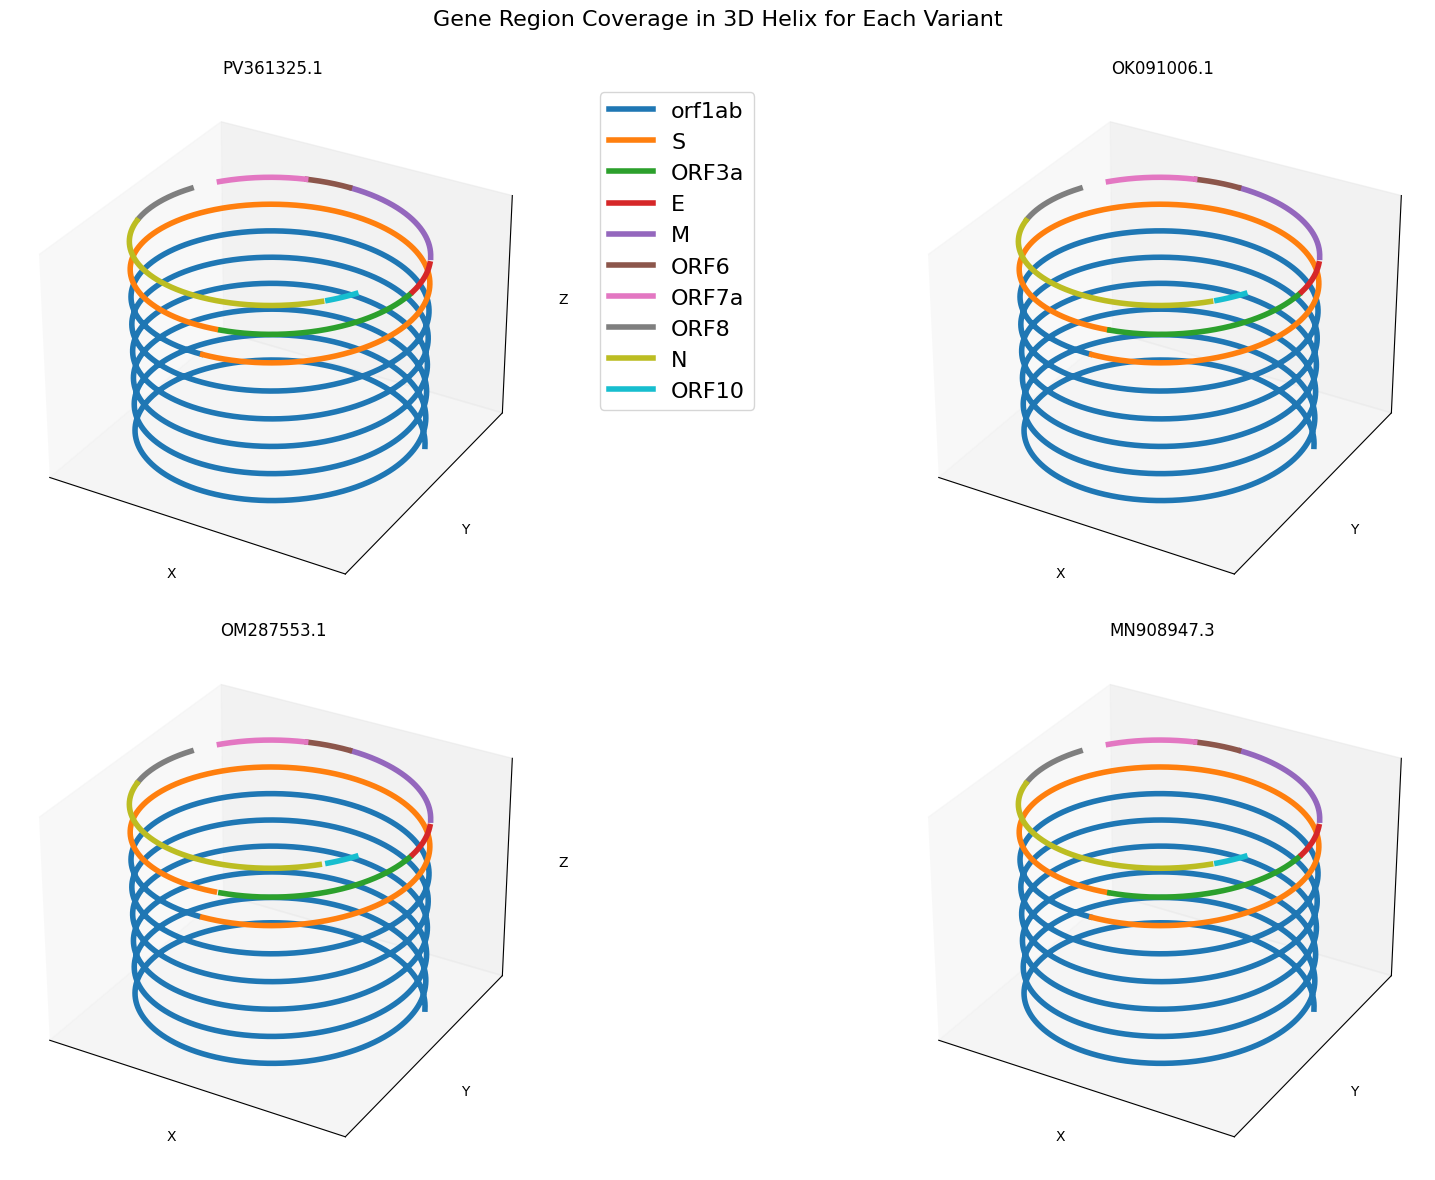

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

df = pd.read_csv("results/gene_coverage_per_variant.csv")

gene_regions = {
    "orf1ab": (266, 21555),
    "S": (21563, 25384),
    "ORF3a": (25393, 26220),
    "E": (26245, 26472),
    "M": (26523, 27191),
    "ORF6": (27202, 27387),
    "ORF7a": (27394, 27759),
    "ORF8": (27894, 28259),
    "N": (28274, 29533),
    "ORF10": (29558, 29674),
}

genome_length = 30000
radius = 10
num_turns = 8

fig = plt.figure(figsize=(18, 12))
colors = plt.cm.get_cmap("tab10", len(gene_regions))

for idx, row in df.iterrows():
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
    variant_id = row["Variant_ID"]
    
    for gi, (gene, (start, end)) in enumerate(gene_regions.items()):
        gene_len = end - start + 1
        covered_len = min(row[gene], gene_len) 

        positions = np.arange(start, start + covered_len)
        theta = 2 * np.pi * num_turns * (positions / genome_length)
        z = positions / genome_length
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)

        ax.plot(x, y, z, color=colors(gi), linewidth=4, label=gene)

    ax.set_title(f"{variant_id}", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    if idx == 0:
        ax.legend(loc="upper left", bbox_to_anchor=(1.1, 1.0), fontsize=16)

fig.suptitle("Gene Region Coverage in 3D Helix for Each Variant", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig("results/helix_gene_coverage_per_variant.png")
plt.show()


Total spike mutations: 173
Type
SNP          134
Deletion      30
Insertion      9
Name: count, dtype: int64


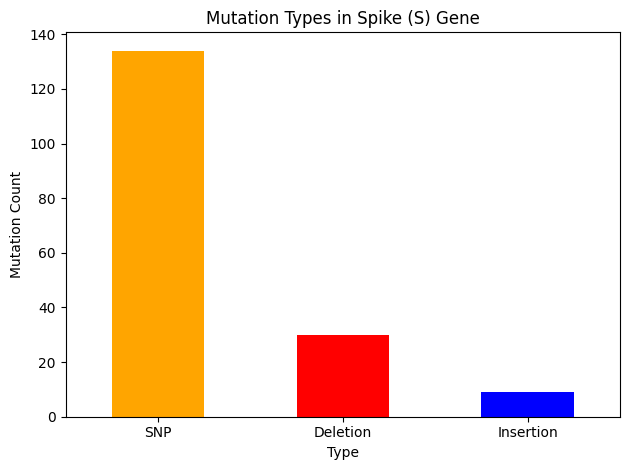

In [17]:
df = pd.read_csv("results/mutations_annotated_with_genes.csv")
spike_mutations = df[df["Gene"] == "S"]

spike_mutations.to_csv("results/spike_mutations.csv", index=False)
print(f"Total spike mutations: {len(spike_mutations)}")
print(spike_mutations["Type"].value_counts())


import matplotlib.pyplot as plt

spike_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in Spike (S) Gene", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/spike_mutation_types.png")
plt.show()

In [18]:
indels = spike_mutations[spike_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/spike_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to spike_insertions_deletions.csv")

Saved high-impact mutations to spike_insertions_deletions.csv


In [19]:
spike_mutations[spike_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

Position
21846    3
23412    3
23004    3
23613    3
22926    2
21987    2
21618    2
23064    2
23072    2
23084    2
Name: count, dtype: int64

Total ORF1ab mutations: 126
Type
SNP         114
Deletion     12
Name: count, dtype: int64


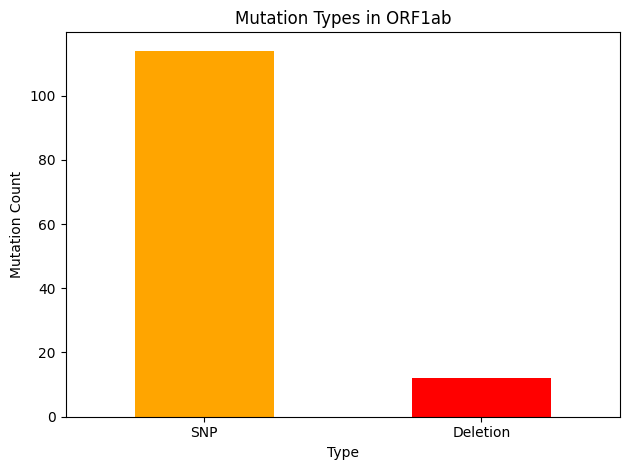

In [20]:
orf1ab_mutations = df[df["Gene"] == "orf1ab"]
orf1ab_mutations.to_csv("results/orf1ab_mutations.csv", index=False)

print(f"Total ORF1ab mutations: {len(orf1ab_mutations)}")
print(orf1ab_mutations["Type"].value_counts())

orf1ab_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in ORF1ab", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/orf1ab_mutation_types.png")
plt.show()


In [21]:
indels = orf1ab_mutations[orf1ab_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/orf1ab_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to orf1ab_insertions_deletions.csv")


orf1ab_mutations[orf1ab_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

Saved high-impact mutations to orf1ab_insertions_deletions.csv


Position
3037     3
14408    3
10029    2
15451    2
16466    2
5386     1
5514     1
5184     1
5239     1
2832     1
Name: count, dtype: int64

Total ORF3a mutations: 3
Type
SNP    3
Name: count, dtype: int64


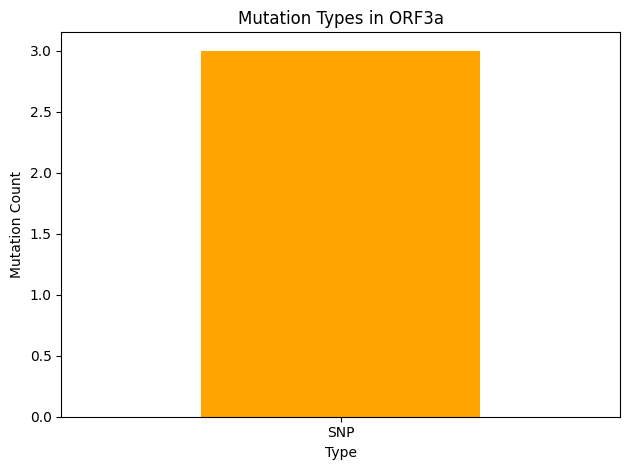

Saved high-impact mutations to orf3a_insertions_deletions.csv


Position
25478    2
25593    1
Name: count, dtype: int64

In [22]:
orf3a_mutations = df[df["Gene"] == "ORF3a"]
orf3a_mutations.to_csv("results/ORF3a_mutations.csv", index=False)

print(f"Total ORF3a mutations: {len(orf3a_mutations)}")
print(orf3a_mutations["Type"].value_counts())

orf3a_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in ORF3a", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/orf3a_mutation_types.png")
plt.show()

indels = orf3a_mutations[orf3a_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/orf3a_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to orf3a_insertions_deletions.csv")
orf3a_mutations[orf3a_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

Total E mutations: 1
Type
SNP    1
Name: count, dtype: int64


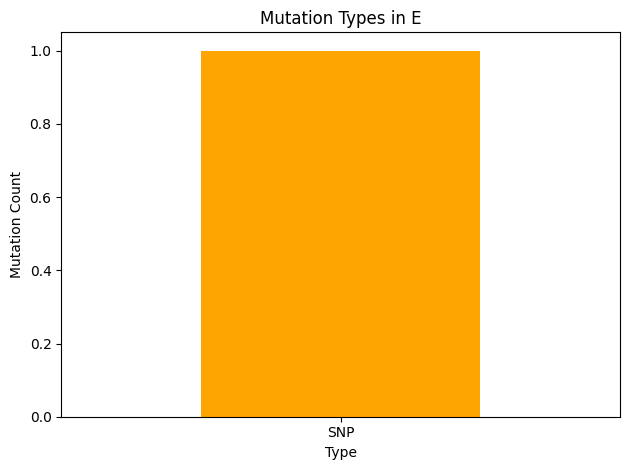

Saved high-impact mutations to E_insertions_deletions.csv


Position
26279    1
Name: count, dtype: int64

In [23]:
E_mutations = df[df["Gene"] == "E"]
E_mutations.to_csv("results/E_mutations.csv", index=False)

print(f"Total E mutations: {len(E_mutations)}")
print(E_mutations["Type"].value_counts())

E_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in E", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/E_mutation_types.png")
plt.show()

indels = E_mutations[E_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/E_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to E_insertions_deletions.csv")

E_mutations[E_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

Total M mutations: 5
Type
SNP    5
Name: count, dtype: int64


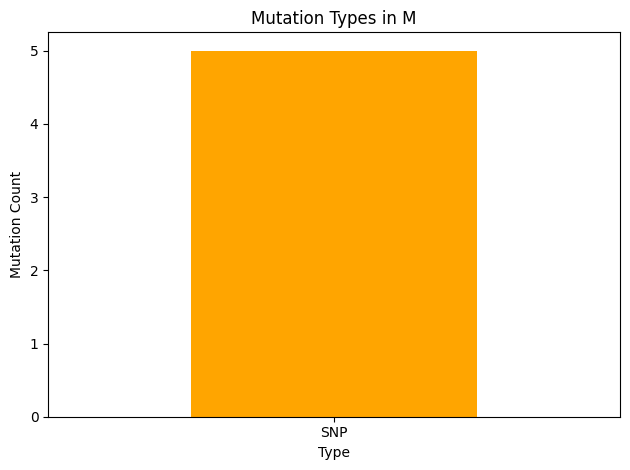

Saved high-impact mutations to M_insertions_deletions.csv


Position
26776    2
26539    1
26586    1
26718    1
Name: count, dtype: int64

In [24]:
M_mutations = df[df["Gene"] == "M"]
M_mutations.to_csv("results/M_mutations.csv", index=False)

print(f"Total M mutations: {len(M_mutations)}")
print(M_mutations["Type"].value_counts())

M_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in M", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/M_mutation_types.png")
plt.show()

indels = M_mutations[M_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/M_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to M_insertions_deletions.csv")
M_mutations[M_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

Total N mutations: 23
Type
SNP         13
Deletion    10
Name: count, dtype: int64


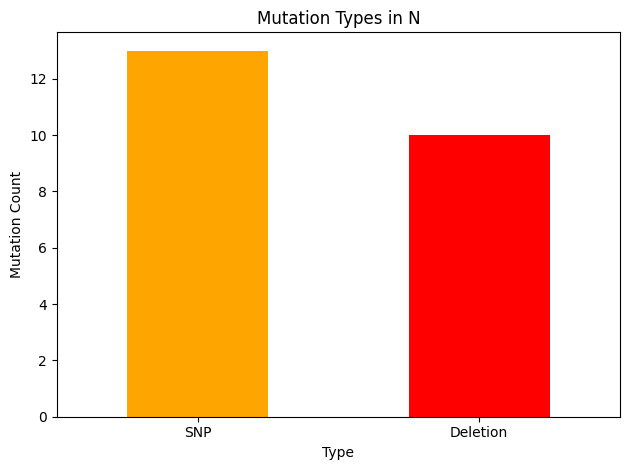

Saved high-impact mutations to N_insertions_deletions.csv


Position
28890    3
28280    2
28470    2
29411    2
28320    1
28891    1
28892    1
28925    1
Name: count, dtype: int64

In [25]:
N_mutations = df[df["Gene"] == "N"]
N_mutations.to_csv("results/N_mutations.csv", index=False)

print(f"Total N mutations: {len(N_mutations)}")
print(N_mutations["Type"].value_counts())

N_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in N", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/N_mutation_types.png")
plt.show()

indels = N_mutations[N_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/N_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to N_insertions_deletions.csv")
N_mutations[N_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

Total ORF6 mutations: 1
Type
SNP    1
Name: count, dtype: int64


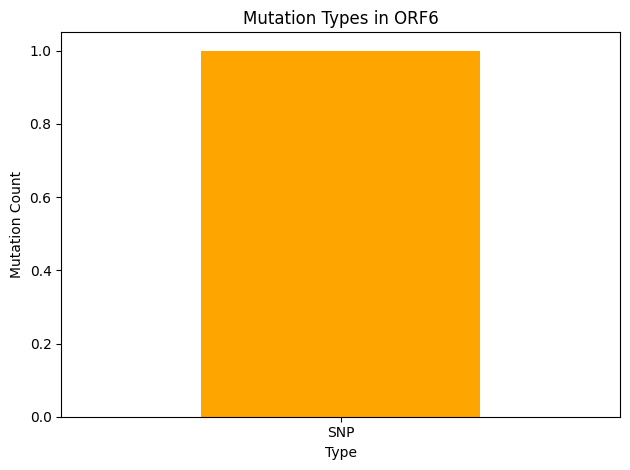

Saved high-impact mutations to ORF6_insertions_deletions.csv


Position
27268    1
Name: count, dtype: int64

In [26]:
ORF6_mutations = df[df["Gene"] == "ORF6"]
ORF6_mutations.to_csv("results/ORF6_mutations.csv", index=False)

print(f"Total ORF6 mutations: {len(ORF6_mutations)}")
print(ORF6_mutations["Type"].value_counts())

ORF6_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in ORF6", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/ORF6_mutation_types.png")
plt.show()

indels = ORF6_mutations[ORF6_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/ORF6_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to ORF6_insertions_deletions.csv")
ORF6_mutations[ORF6_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

Total ORF7a mutations: 2
Type
SNP    2
Name: count, dtype: int64


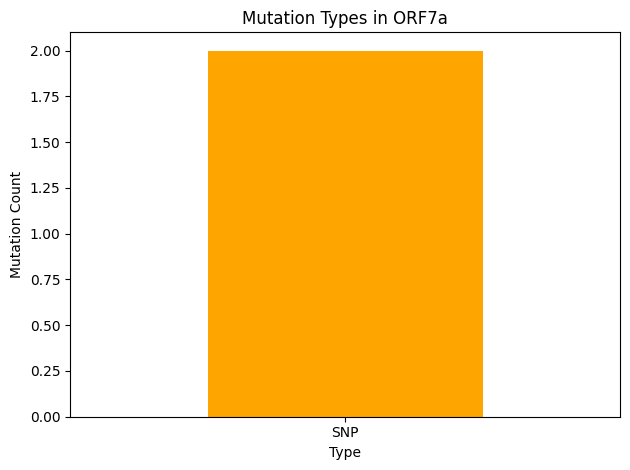

Saved high-impact mutations to ORF7a_insertions_deletions.csv


Position
27647    2
Name: count, dtype: int64

In [27]:
ORF7a_mutations = df[df["Gene"] == "ORF7a"]
ORF7a_mutations.to_csv("results/ORF7a_mutations.csv", index=False)

print(f"Total ORF7a mutations: {len(ORF7a_mutations)}")
print(ORF7a_mutations["Type"].value_counts())

ORF7a_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in ORF7a", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/ORF7a_mutation_types.png")
plt.show()

indels = ORF7a_mutations[ORF7a_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/ORF7a_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to ORF7a_insertions_deletions.csv")
ORF7a_mutations[ORF7a_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

Total ORF8 mutations: 3
Type
Deletion    3
Name: count, dtype: int64


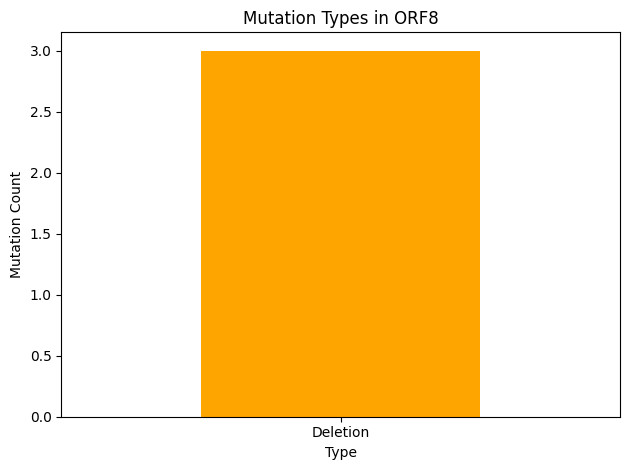

Saved high-impact mutations to ORF8_insertions_deletions.csv


Series([], Name: count, dtype: int64)

In [28]:
ORF8_mutations = df[df["Gene"] == "ORF8"]
ORF8_mutations.to_csv("results/ORF8_mutations.csv", index=False)

print(f"Total ORF8 mutations: {len(ORF8_mutations)}")
print(ORF8_mutations["Type"].value_counts())

ORF8_mutations["Type"].value_counts().plot(
    kind="bar", title="Mutation Types in ORF8", color=["orange", "red", "blue"]
)

plt.ylabel("Mutation Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/ORF8_mutation_types.png")
plt.show()

indels = ORF8_mutations[ORF8_mutations["Type"].isin(["Insertion", "Deletion"])]
indels.to_csv("results/ORF8_insertions_deletions.csv", index=False)
print("Saved high-impact mutations to ORF8_insertions_deletions.csv")
ORF8_mutations[ORF8_mutations["Type"] == "SNP"]["Position"].value_counts().head(10)

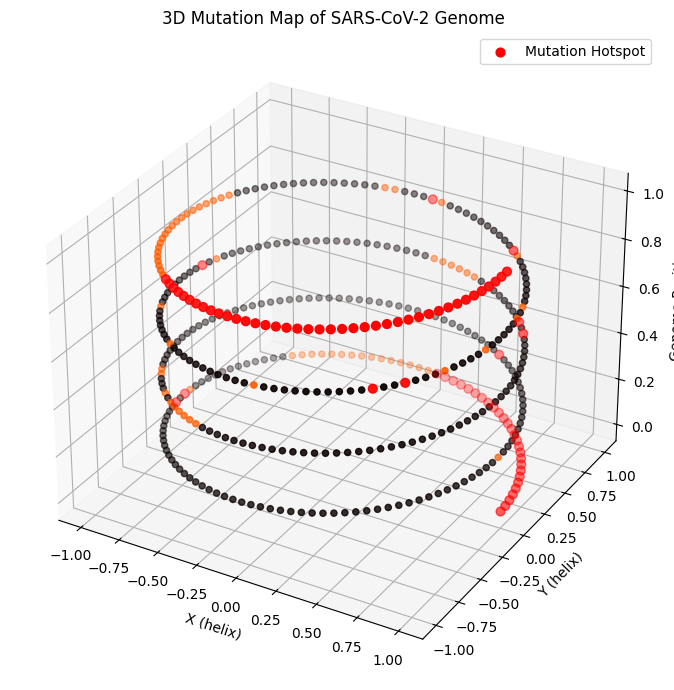

Genome positions covered in the plot: 432
From position 1 to 29912
Genome coverage: 29912 bases


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv("results/mutations_annotated_with_genes.csv")

position_counts = df["Position"].value_counts().sort_index()

positions = position_counts.index.to_numpy()
counts = position_counts.values

theta = np.linspace(0, 8 * np.pi, len(positions))
z = np.linspace(0, 1, len(positions))
x = np.cos(theta)
y = np.sin(theta)

norm_counts = (counts - counts.min()) / (counts.max() - counts.min())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=norm_counts, cmap='hot', s=20)

threshold = np.percentile(counts, 95)
hotspots = counts >= threshold
ax.scatter(x[hotspots], y[hotspots], z[hotspots], c='red', s=40, label='Mutation Hotspot')

ax.set_title("3D Mutation Map of SARS-CoV-2 Genome")
ax.set_xlabel("X (helix)")
ax.set_ylabel("Y (helix)")
ax.set_zlabel("Genome Position")
plt.legend()
plt.savefig("results/3D_Mutation_Map_of_SARS-CoV-2_Genome.png")
plt.tight_layout()
plt.show()

print(f"Genome positions covered in the plot: {len(positions)}")
print(f"From position {positions.min()} to {positions.max()}")
print(f"Genome coverage: {(positions.max() - positions.min()) + 1} bases")



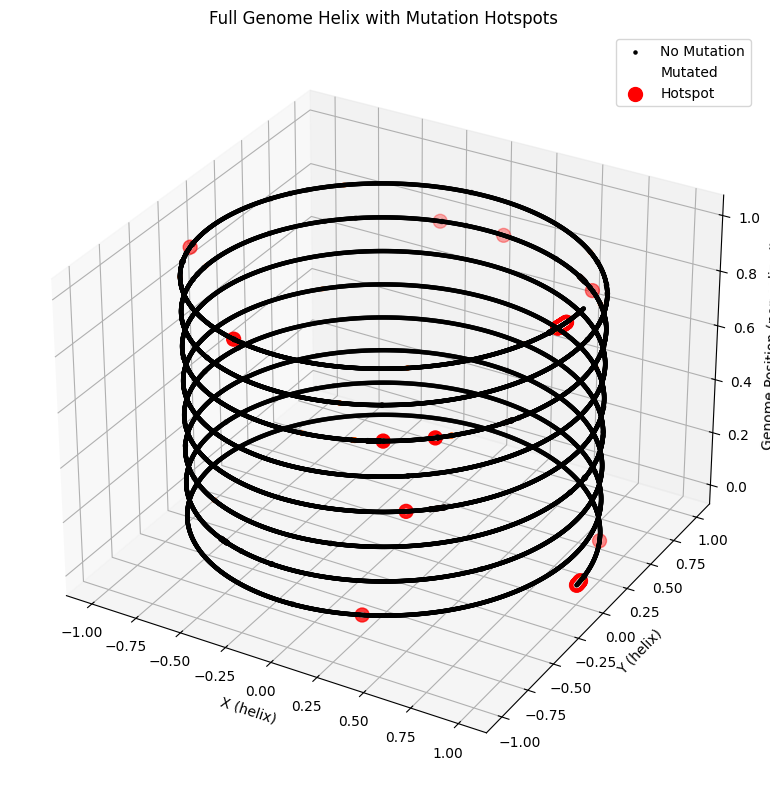

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv("results/mutations_annotated_with_genes.csv")
position_counts = df["Position"].value_counts()

positions = np.arange(1, genome_length + 1)

counts = np.array([position_counts.get(pos, 0) for pos in positions])

theta = 2 * np.pi * 8 * (positions / genome_length)
z = positions / genome_length
x = np.cos(theta)
y = np.sin(theta)

norm_counts = (counts - counts.min()) / (counts.max() - counts.min() + 1e-8)  

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='black', s=5, label='No Mutation')

mutated = counts > 0
sc = ax.scatter(x[mutated], y[mutated], z[mutated],
                c=norm_counts[mutated], cmap='hot', s=10, label='Mutated')

threshold = np.percentile(counts[counts > 0], 95)
hotspots = counts >= threshold
ax.scatter(x[hotspots], y[hotspots], z[hotspots],
           c='red', s=100, label='Hotspot')

ax.set_title("Full Genome Helix with Mutation Hotspots")
ax.set_xlabel("X (helix)")
ax.set_ylabel("Y (helix)")
ax.set_zlabel("Genome Position (normalized)")
ax.legend(loc="upper right")
plt.tight_layout()
plt.savefig("results/full_genome_mutation_helix1.png")
plt.show()

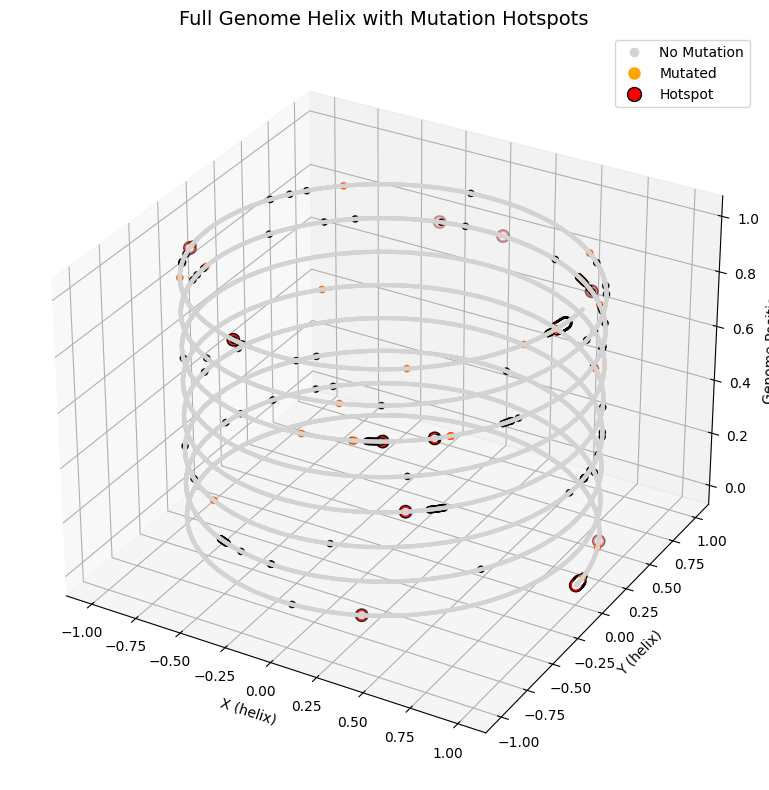

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv("results/mutations_annotated_with_genes.csv")
position_counts = df["Position"].value_counts()

genome_length = 30000
positions = np.arange(1, genome_length + 1)

counts = np.array([position_counts.get(pos, 0) for pos in positions])

theta = 2 * np.pi * 8 * (positions / genome_length)
z = positions / genome_length
x = np.cos(theta)
y = np.sin(theta)

norm_counts = (counts - counts.min()) / (counts.max() - counts.min() + 1e-8)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='lightgray', s=4, label='No Mutation', alpha=0.5)

mutated = counts > 0
sc = ax.scatter(x[mutated], y[mutated], z[mutated],
                c=norm_counts[mutated], cmap='hot', s=20, label='Mutated', alpha=0.9)

threshold = np.percentile(counts[counts > 0], 95)
hotspots = counts >= threshold
ax.scatter(x[hotspots], y[hotspots], z[hotspots],
           c='red', s=80, label='Hotspot', edgecolors='black')

ax.set_title("Full Genome Helix with Mutation Hotspots", fontsize=14)
ax.set_xlabel("X (helix)")
ax.set_ylabel("Y (helix)")
ax.set_zlabel("Genome Position")
plt.tight_layout()
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='lightgray', label='No Mutation',
           markersize=6, linestyle='None'),
    Line2D([0], [0], marker='o', color='orange', label='Mutated',
           markersize=8, linestyle='None'),
    Line2D([0], [0], marker='o', color='red', markeredgecolor='black',
           label='Hotspot', markersize=10, linestyle='None')
]
ax.legend(handles=legend_elements, loc="upper right")

plt.savefig("results/full_genome_mutation_helix2.png")
plt.show()


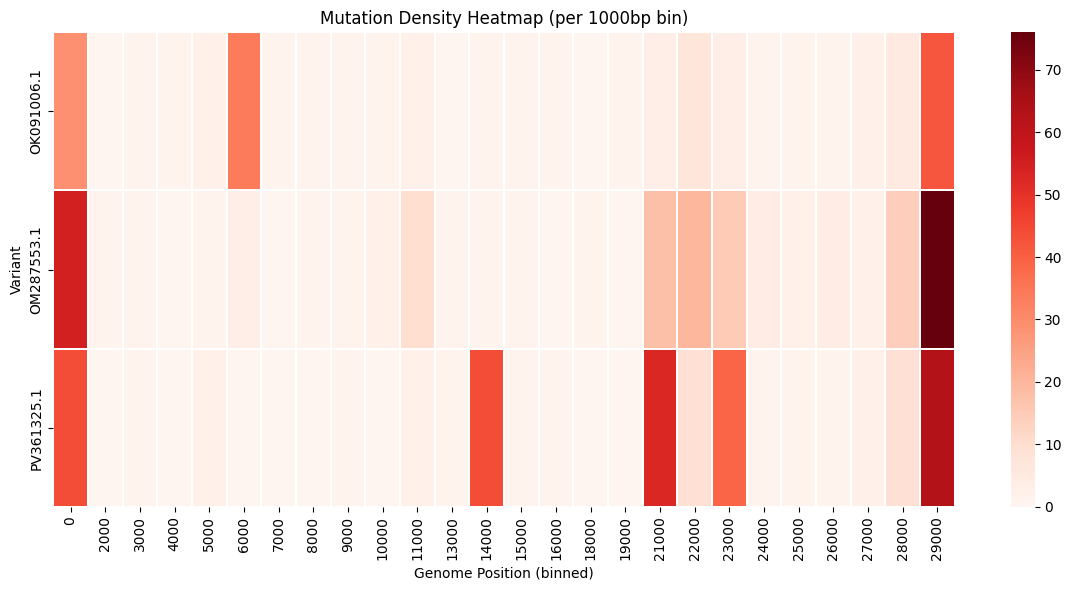

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv("results/mutations_annotated_with_genes.csv")

bin_size = 1000
df['Position_Bin'] = (df['Position'] // bin_size) * bin_size

heatmap_data = df.groupby(['Variant_ID', 'Position_Bin']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=0.2)
plt.title("Mutation Density Heatmap (per 1000bp bin)")
plt.xlabel("Genome Position (binned)")
plt.ylabel("Variant")
plt.tight_layout()
plt.savefig("results/heatmap_mutation_density.png")

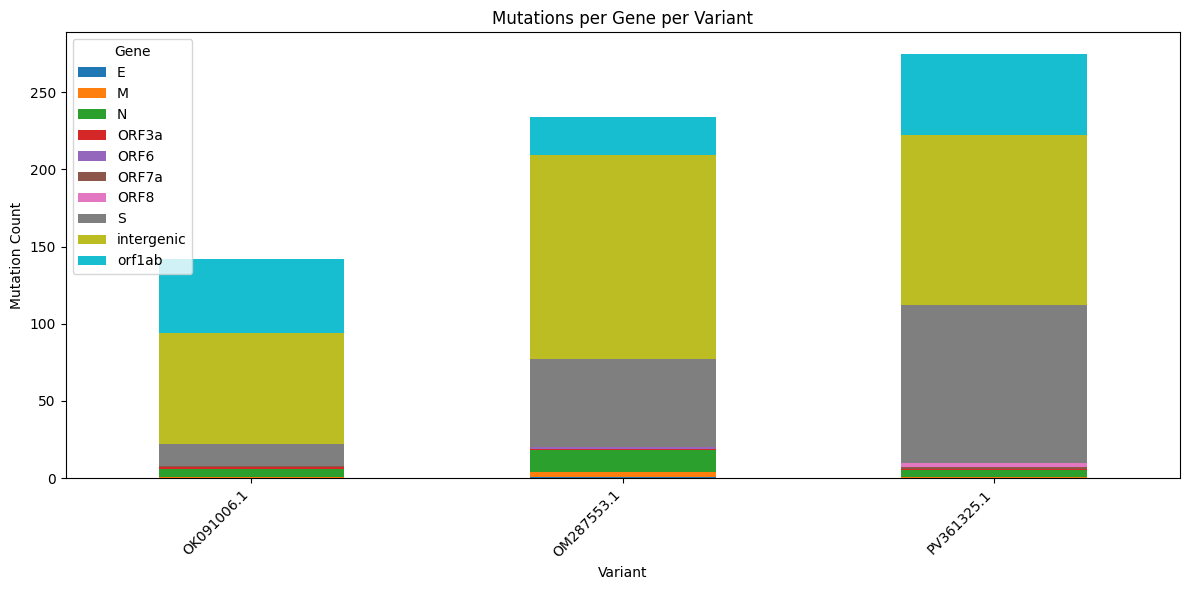

In [33]:
gene_counts = df.groupby(['Variant_ID', 'Gene']).size().unstack(fill_value=0)
gene_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title("Mutations per Gene per Variant")
plt.xlabel("Variant")
plt.ylabel("Mutation Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("results/stacked_bar_mutations_per_gene.png")

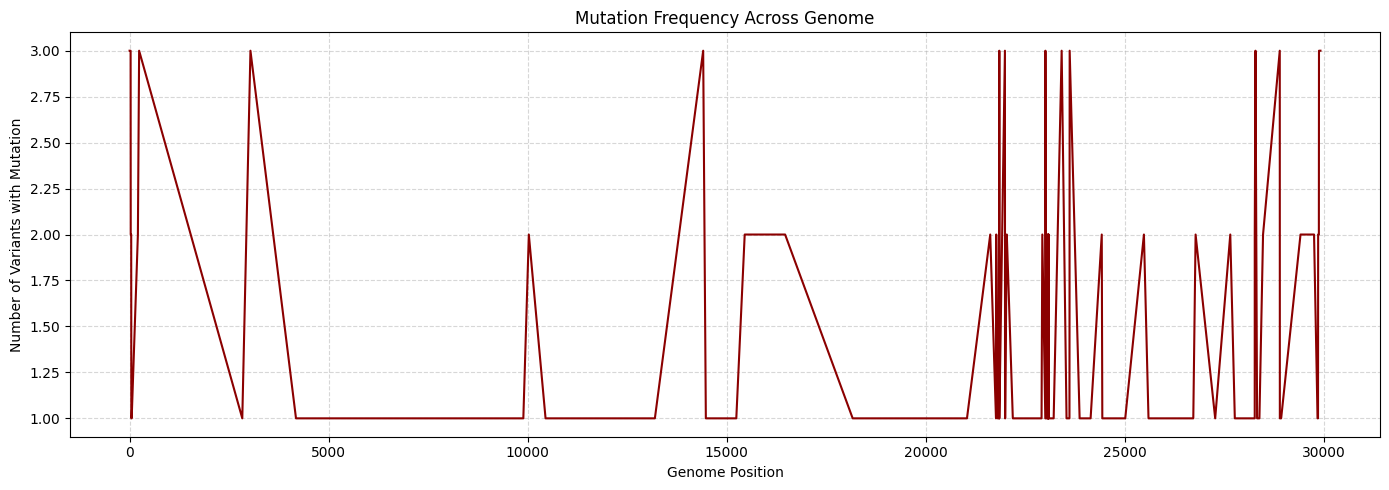

In [34]:
position_freq = df['Position'].value_counts().sort_index()

plt.figure(figsize=(14, 5))
plt.plot(position_freq.index, position_freq.values, color='darkred')
plt.title("Mutation Frequency Across Genome")
plt.xlabel("Genome Position")
plt.ylabel("Number of Variants with Mutation")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("results/lineplot_mutation_frequency.png")